In [1]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import gc
import sys
import multiprocessing as mp
import matplotlib.pyplot as plt
from datetime import datetime
from tempfile import TemporaryFile

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig

#machine learning packages
import sklearn
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats

import tensorflow as tf
from tensorflow.python.framework import ops

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.utils import Sequence, plot_model
from keras.constraints import unit_norm
from keras import regularizers
from keras.callbacks import EarlyStopping, Callback, TensorBoard, ReduceLROnPlateau
import keras_metrics as km
from keras.models import load_model

from models.v3 import create_model
from models.custom_metrics import auroc, auprc, recall_m, precision_m, f1_m

import cv2

#notify the OS about GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/gpf

In [2]:
#parsing command line arguments
# -----parsing command line arguments-----#
parser = argparse.ArgumentParser(description='Training CNN model to predict STARR-seq enhancers based on chromatin accessbility and histone marks')
parser.add_argument('-w', '--cell_types', type=str, help='comma separated string of cell_types')
parser.add_argument('-x', '--in_dir', type=str, help='input_directory')
parser.add_argument('-y', '--cell_name', type=str, help='name of the cell')
parser.add_argument('-z', '--out_dir', type=str, help='output_directory')
parser.add_argument('-a', '--track1_peaks', type=str, help='chromatin accessibility peak')
parser.add_argument('-b', '--track2_peaks', type=str, help='ChIP-seq H3K27ac peak')
parser.add_argument('-c', '--track3_peaks', type=str, help='ChIP-seq H3K4me3 peak')
parser.add_argument('-d', '--track4_peaks', type=str, help='ChIP-seq H3K9ac peak')
parser.add_argument('-e', '--track5_peaks', type=str, help='ChIP-seq H3K4me1 peak')
parser.add_argument('-f', '--track1_bw', type=str, help='chromatin accessibility bigWig')
parser.add_argument('-g', '--track2_bw', type=str, help='ChIP-seq H3K27ac bigWig')
parser.add_argument('-i', '--track3_bw', type=str, help='ChIP-seq H3K4me3 bigWig')
parser.add_argument('-j', '--track4_bw', type=str, help='ChIP-seq H3K9ac bigWig')
parser.add_argument('-k', '--track5_bw', type=str, help='ChIP-seq H3K4me1 bigWig')

cell_type = "NPC"

#simulate command line input
seqdir = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/" + cell_type + "/"
cmdline_str='-w ' + " HepG2,K562,A549,HCT116,MCF-7 " + \
    ' -x ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/encoded_2overlap/DNase/" + \
    ' -y ' + cell_type + \
    ' -z ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/output/" + \
    ' -a ' + seqdir+cell_type+".DNase-seq.narrowPeak" + \
    ' -b ' + seqdir+cell_type+".ChIP-seq.H3K27ac.narrowPeak" + \
    ' -c ' + seqdir+cell_type+".ChIP-seq.H3K4me3.narrowPeak" + \
    ' -d ' + seqdir+cell_type+".ChIP-seq.H3K9ac.narrowPeak" + \
    ' -e ' + seqdir+cell_type+".ChIP-seq.H3K4me1.narrowPeak" + \
    ' -f ' + seqdir+cell_type+".DNase-seq.bigWig" + \
    ' -g ' + seqdir+cell_type+".ChIP-seq.H3K27ac.bigWig" + \
    ' -i ' + seqdir+cell_type+".ChIP-seq.H3K4me3.bigWig" + \
    ' -j ' + seqdir+cell_type+".ChIP-seq.H3K9ac.bigWig" + \
    ' -k ' + seqdir+cell_type+".ChIP-seq.H3K4me1.bigWig"

seq_names = ["DNase", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]

#check if the files are there
args = parser.parse_args(cmdline_str.split())
args.cell_types = args.cell_types.split(",")
for cell in args.cell_types:
    for seq in seq_names:
        pos_file = args.in_dir + cell + "." + seq + ".pos.tsv"
        if not os.path.exists(pos_file):
            print(pos_file + " file does not exist")
            exit(1)
        neg_file = args.in_dir + cell + "." + seq + ".neg.tsv"
        if not os.path.exists(neg_file):
            print(neg_file + " file does not exist")
            exit(1)
            
for key, value in vars(args).items():
    if key == "cell_types" or key == "in_dir" or key == "out_dir" or key == "cell_name":
        continue
    else:
        if not os.path.exists(value):
            print(key + " argument file does not exist")
            exit(1)
print("all files found!")

#construct a set of autosome + X chromosome names
chromosomes = []
for i in range(1,23):
    chromosomes.append("chr"+str(i))
chromosomes.append("chrX")
print(chromosomes)
print("all files found!")

all files found!
['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
all files found!


In [3]:
total_val = []
total_pred = []
total_50_pred = []
for temp_chrom in chromosomes:
    val = pd.read_csv(args.out_dir + args.cell_name + "." + temp_chrom + "." + "validation_regions.bed", sep="\t",header=None)
    pred = pd.read_csv(args.out_dir + args.cell_name + "." + temp_chrom + "." + "prediction_regions.bed", sep="\t",header=None)
    pred_50 = pd.read_csv(args.out_dir + args.cell_name + "." + temp_chrom + "." + "prediction_pos_regions.50.bed", sep="\t",header=None)

    if len(total_val) == 0:
        total_val = val
    else:
        total_val = total_val.append(val)

    if len(total_pred) == 0:
        total_pred = pred
    else:
        total_pred = total_pred.append(pred)

    if len(total_50_pred) == 0:
        total_50_pred = pred_50
    else:
        total_50_pred = total_50_pred.append(pred_50)

total_pred.to_csv(args.out_dir + args.cell_name + ".all.prediction_regions.bed", sep="\t",header=None, index=False)
total_50_pred.to_csv(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.bed", sep="\t",header=None, index=False)
total_val.to_csv(args.out_dir + args.cell_name + ".all.validation_regions.bed", sep="\t",header=None, index=False)
pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.bed").sort().merge(c=5, o="mean").saveas(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.bed")

window_size = 4000
def bigWigAverageOverBed(x, bigwig):
    return bigwig.stats(x.chrom, x.start, x.stop, nBins=int(window_size/10))

def get_signal(input_list):
    print(input_list)
    sys.stdout.flush()
    return [bigWigAverageOverBed(x, pyBigWig.open(input_list[0])) for x in pybedtools.BedTool(input_list[1])]

In [4]:
p = mp.Pool(5)
input_list = [[x, args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.bed"] 
              for x in [args.track1_bw, args.track2_bw, args.track3_bw, args.track4_bw, args.track5_bw]]
sys.stdout.flush()
signal_files = p.map(get_signal, input_list)
p.close()
p.join()

print("finished multiprocess IO")
sys.stdout.flush()

['/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/NPC/NPC.ChIP-seq.H3K4me1.bigWig', '/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/output/NPC.all.prediction_pos_regions.50.bed']
['/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/NPC/NPC.ChIP-seq.H3K27ac.bigWig', '/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/output/NPC.all.prediction_pos_regions.50.bed']
['/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/NPC/NPC.ChIP-seq.H3K4me3.bigWig', '/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/output/NPC.all.prediction_pos_regions.50.bed']
['/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/NPC/NPC.ChIP-seq.H3K9ac.bigWig', '/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/output/NPC.all.prediction_pos_regions.50.bed']
['/gpfs/ysm/scratch60/gerstein/zc264/ChromVar

In [5]:
#reformat the validation values
#using lists reduces memory footprint
for s in range(len(signal_files)):
    signal_files[s] = [np.array(i) for i in signal_files[s]]

predicted_pos = pybedtools.BedTool().window_maker(b=args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.bed", n=int(window_size/10))
print(predicted_pos.count())
predicted_pos.saveas(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.breakdown.bed")

7048800


<BedTool(/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/output/NPC.all.prediction_pos_regions.50.breakdown.bed)>

In [6]:
x_validation = []
for i in range(len(signal_files[0])):
    x_validation.append(np.array([signal_file[i] for signal_file in signal_files]))
x_validation = np.nan_to_num(np.array(x_validation, dtype=float))
#x_validation[:, [0, 2], :] = x_validation[:, [2, 0], :]
print(x_validation.shape)

x_validation = np.expand_dims(x_validation, axis=3)
print(x_validation.shape)

(17622, 5, 400)
(17622, 5, 400, 1)


In [7]:
model = create_model(width=int(window_size/10))
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
adam = Adam(lr=5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5)
model.compile(loss='binary_crossentropy', optimizer=adam, 
              metrics = ['accuracy', auroc, auprc, f1_m, recall_m, precision_m])
model.load_weights('./saved_models/DNase_hg38.v3.h5')
model.summary()

/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/models/v3.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 400, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 400, 128)  3968        input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 128)          0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            1032        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_2 (D

In [8]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def cam_pred_multi_1d(model, X):
    """GradCAM method for visualizing input saliency."""
    layer_name = "conv2d_7"

    y_c = model.output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([X])
    weights = np.mean(grads_val, axis=(1, 2))

    all_cam = []
    for i in range(len(weights)):
        cam = np.dot(output[i], weights[i])
        cam = cv2.resize(cam, (int(window_size/10), 1), cv2.INTER_LINEAR)
        cam = np.maximum(cam, 0)
        all_cam.append(cam[0])

    all_cam = np.array(all_cam)
    return all_cam

def cam_pred_multi_5d(model, X):
    """GradCAM method for visualizing input saliency."""
    layer_name = "conv2d_2"

    y_c = model.output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([X])
    weights = np.mean(grads_val, axis=(1, 2))

    all_cam = []
    for i in range(len(weights)):
        cam = np.dot(output[i], weights[i])
        cam = cv2.resize(cam, (int(window_size/10), 5), cv2.INTER_LINEAR)
        cam = np.maximum(cam, 0)
        all_cam.append(cam)

    all_cam = np.array(all_cam)
    return all_cam


0,000
10,000
(5, 17622, 400)


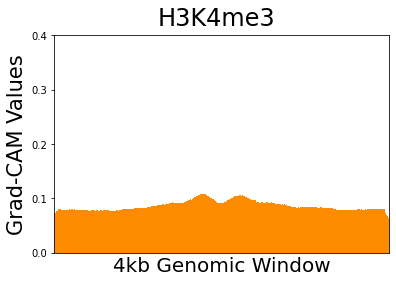

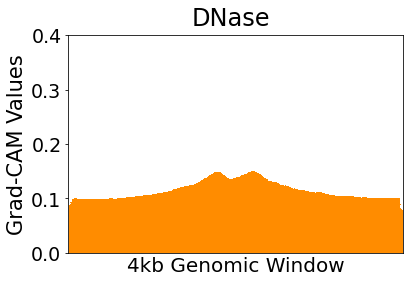

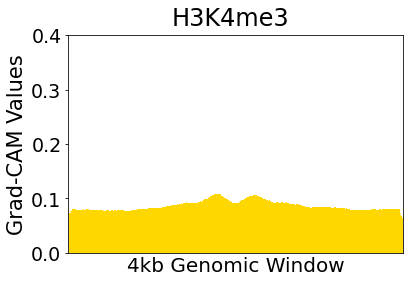

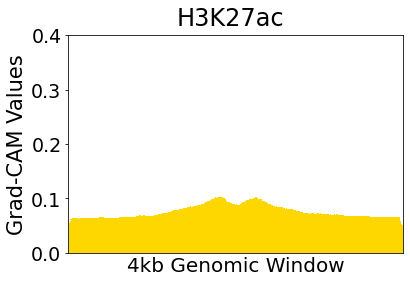

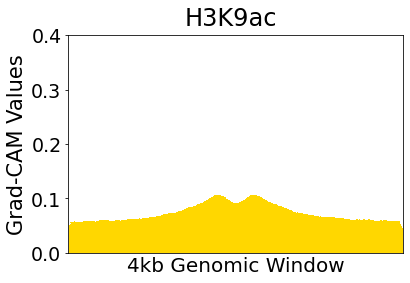

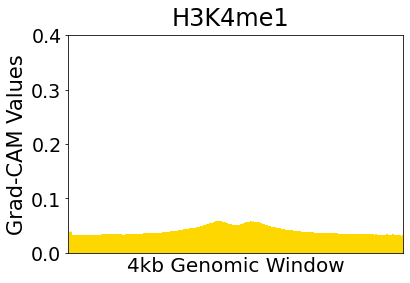

In [9]:
#plot raw_pred_5d
raw_pred_5d = []
stride = 1000
for i in range(int(len(x_validation)/stride) + 1):
    if (i % 10 == 0):
        print(str(i) + ",000")
    raw_pred_5d.extend(cam_pred_multi_5d(model, x_validation[i * stride: (i+1) * stride]))
raw_pred_5d = np.array(raw_pred_5d)

raw_pred_per_seq = np.swapaxes(raw_pred_5d,0,1)
print(raw_pred_per_seq.shape)


new_seq_names = ["DNase", "H3K4me3", "H3K27ac", "H3K9ac", "H3K4me1"]

i = 1
fig = plt.figure()
box = plt.boxplot(raw_pred_per_seq[i], showfliers=False)
for _, line_list in box.items():
    for line in line_list:
        line.set_color('darkorange')
plt.ylim([0, 0.4])
plt.xticks([])
fig.suptitle(new_seq_names[i], fontsize=24)
plt.ylabel('Grad-CAM Values', fontsize=21)
plt.xlabel('4kb Genomic Window', fontsize=20)
plt.rc('ytick', labelsize=19)    # fontsize of the tick labels
plt.show();

for i in range(len(new_seq_names)):
    fig = plt.figure()
    box = plt.boxplot(raw_pred_per_seq[i], showfliers=False)
    for _, line_list in box.items():
        for line in line_list:
            if new_seq_names[i] == "DNase":
                line.set_color('darkorange')
            else:
                line.set_color('gold')
    plt.ylim([0, 0.4])
    plt.xticks([])
    fig.suptitle(new_seq_names[i], fontsize=24)
    plt.ylabel('Grad-CAM Values', fontsize=21)
    plt.xlabel('4kb Genomic Window', fontsize=20)
    plt.rc('ytick', labelsize=19)    # fontsize of the tick labels
    plt.show();
    

In [10]:
raw_pred_1d = []
stride = 1000
for i in range(int(len(x_validation)/stride) + 1):
    if (i % 10 == 0):
        print(str(i) + ",000")
    raw_pred_1d.extend(cam_pred_multi_1d(model, x_validation[i * stride: (i+1) * stride]))
raw_pred_1d = np.array(raw_pred_1d)

0,000
10,000


In [11]:
print(stats.describe(raw_pred_1d.flatten()))

#format into bed with proper regions
df = pd.read_csv(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.breakdown.bed", sep="\t",header=None)
df[4] = "bin"
df[5] = raw_pred_1d.flatten()
df.to_csv(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.1d_breakdown.raw.bed", sep="\t",header=None, index=False)

#refine positive predictions, based on fixed baseline, the mean skews enrichment in a weird way
grad_cam_filter = np.mean(raw_pred_1d.flatten())
# grad_cam_filter = 0.0002
refined_idx = df[5]>grad_cam_filter
df[refined_idx].to_csv(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.1d_breakdown.filtered.bed", sep="\t",header=None, index=False)

pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.1d_breakdown.raw.bed").sort().merge(c=5, o="mean").saveas(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.1d_raw.bed")
pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.1d_breakdown.filtered.bed").sort().merge(c=5, o="mean").saveas(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.1d_filtered.bed")

#format into bed with proper regions
df = pd.read_csv(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.1d_filtered.bed", sep="\t",header=None)
# df[4] = df[3]
# del df[4]
df[3] = df.index
df.to_csv(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.1d_filtered.bed", sep="\t",header=None, index=False)

DescribeResult(nobs=7048800, minmax=(0.0, 0.42610228), mean=0.008550542, variance=0.00039002305, skewness=3.2252025604248047, kurtosis=13.792839596624429)


In [12]:
# del signal_files
# del raw_pred_5d
# del total_pred
# del total_50_pred
# del total_val
# gc.collect()

#format into bed with proper regions
#format into bed with proper regions
df = pd.read_csv(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.breakdown.bed", sep="\t",header=None)
df[4] = "bin"
df = df.to_numpy()
new_data = raw_pred_per_seq.reshape(-1, raw_pred_per_seq.shape[0])
all_data = np.column_stack((df, new_data))
all_data = pd.DataFrame(all_data)
all_data.to_csv(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.5d_breakdown.raw.bed", sep="\t",header=None, index=False)

In [13]:
print(df.shape)
print(new_data.shape)
#all_data = np.column_stack((df, new_data))
#all_data = pd.DataFrame(all_data)
print(all_data.shape)
print(all_data[refined_idx].shape)

(7048800, 4)
(7048800, 5)
(7048800, 9)
(1573008, 9)


In [14]:
#refine positive predictions, based on fixed baseline, the mean skews enrichment in a weird way
refined_data = all_data[refined_idx]
refined_data.to_csv(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.5d_breakdown.filtered.bed", sep="\t", header=None, index=False)

In [15]:
pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.5d_breakdown.raw.bed").sort().merge(c=[4,5,6,7,8,9], o=["count", "mean", "mean", "mean", "mean", "mean"]).saveas(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.5d_raw.bed")
pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.5d_breakdown.filtered.bed").sort().merge(c=[4,5,6,7,8,9], o=["count", "mean", "mean", "mean", "mean", "mean"]).saveas(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.5d_filtered.bed")

<BedTool(/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/output/NPC.all.prediction_pos_regions.50.5d_filtered.bed)>

In [16]:
X = pd.read_csv(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.5d_filtered.bed", sep="\t",header=None)
X = X.iloc[np.random.choice(X.shape[0], 5000), [4,5,6,7,8]].values
print(X.shape)

(5000, 5)


In [ ]:
import scipy.cluster.hierarchy as sch
#Lets create a dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and then in linkage we have to #specify on which data we apply and engage. This is X dataset
dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Predicted Enhancers')
plt.ylabel('Euclidean Distances of \nFeature Grad-CAM Scores')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

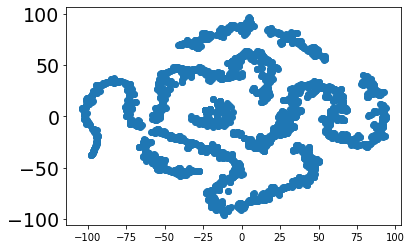

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=16)
tsne_X = tsne.fit_transform(X)
plt.figure()
plt.scatter(tsne_X[: ,0], tsne_X[:, 1])
plt.show();

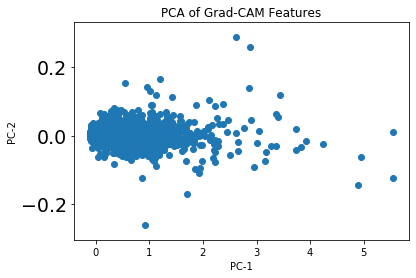

In [19]:
from sklearn.decomposition import PCA

X = pd.read_csv(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.5d_filtered.bed", sep="\t",header=None)
X = X.iloc[:, [4,5,6,7,8]].values

pca = PCA(n_components=2)
PCA_X = pca.fit_transform(X)

plt.figure()
plt.scatter(PCA_X[: ,0], PCA_X[:, 1])
plt.title('PCA of Grad-CAM Features')
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.show();

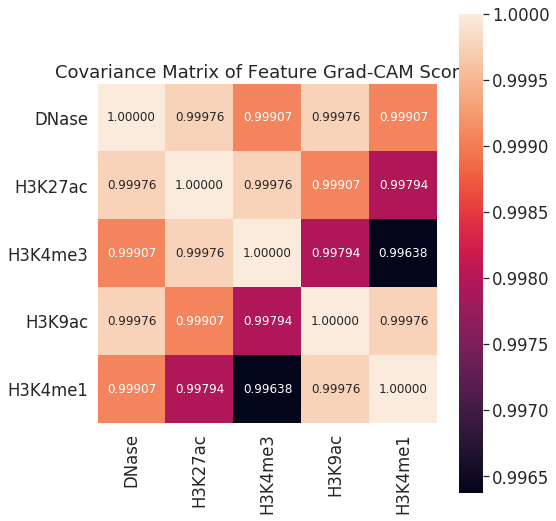

In [20]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

stdsc = StandardScaler()
X_std = stdsc.fit_transform(X[:, [2,1,0,3,4]])
cov_mat = np.corrcoef(X_std.T)
                            
plt.figure(figsize=(8,8))
sns.set(font_scale=1.5)
ax = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.5f',
                 annot_kws={'size': 12},
                 yticklabels=seq_names,
                 xticklabels=seq_names)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Covariance Matrix of Feature Grad-CAM Scores')
plt.tight_layout()
plt.show()
